In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pickle

with open('df_with_patch_object.pickle', 'rb') as f:
    patch_responses = pickle.load(f)
patch_responses.drop('Patch', axis=1, inplace=True)

In [3]:
patch_responses.tail(2)

,Unnamed: 0,patch_id,response_author,resp_parent,resp_msg_id,upstream,response_is_bot,bot_name,patch_author,responder,self_response,email
188532,188532,<z4zhwEnRqCVnnV8RYwKbY9H_TEnHePR6grYfw1toELFA-...,Andreas Schwab <schwab@linux-m68k.org>,<z4zhwEnRqCVnnV8RYwKbY9H_TEnHePR6grYfw1toELFA-...,<874l0k3hd0.fsf@igel.home>,NaN,False,NaN,"('dmitry goldin', 'dgoldin@protonmail.ch')","('andreas schwab', 'schwab@linux-m68k.org')",False,"[Return-Path, X-Spam-Checker-Version, X-Spam-L..."
188533,188533,<z4zhwEnRqCVnnV8RYwKbY9H_TEnHePR6grYfw1toELFA-...,Masahiro Yamada <yamada.masahiro@socionext.com>,<z4zhwEnRqCVnnV8RYwKbY9H_TEnHePR6grYfw1toELFA-...,<CAK7LNATz=j4zyF264rQD4fivw0BaW0nS5kHSBBLEjZbK...,NaN,False,NaN,"('dmitry goldin', 'dgoldin@protonmail.ch')","('masahiro yamada', 'yamada.masahiro@socionext...",False,"[Return-Path, X-Spam-Checker-Version, X-Spam-L..."


In [4]:
import re

# Debian emails seem to have their own format of mailing list names
# I use some regex magic and drop the archive information so that
# I can later aggregate them all together
# <nbd@other.debian.org> archive/latest/746
debian_regex = re.compile('<(.*)> .*')

def try_get_list(email):
    try:
        listname = email.get('X-Mailing-List')
        m = debian_regex.match(listname)
        if not m:
            return listname
        else:
            return m.groups(0)[0]
    except:
        return None

patch_responses['mailing_list'] = patch_responses['email'].map(try_get_list)

Text(0.5, 0, 'Number of responses')

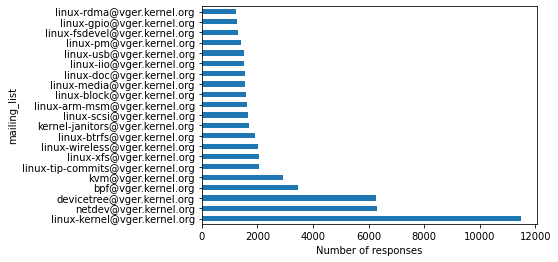

In [5]:
ax = patch_responses.groupby('mailing_list').nunique()['resp_msg_id']\
                .sort_values(ascending=False)[:21]\
                .plot.barh()

ax.set_xlabel('Number of responses')

E.g., how many patches have not been exposed to a review on the mailing list in the last three years?

Which mailing lists are used for review in the kernel community? How many lists? How much traffic? Let us show this data for the last ten years.

Text(0.5, 0, 'Number of patches')

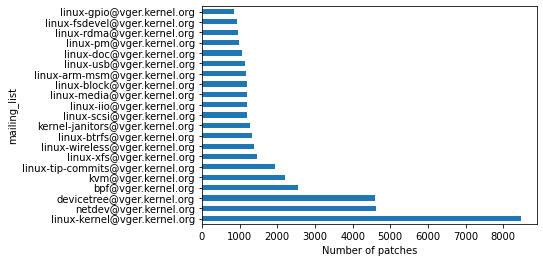

In [6]:
ax = patch_responses.groupby('mailing_list').nunique()['patch_id']\
                .sort_values(ascending=False)[:21]\
                .plot.barh()

ax.set_xlabel('Number of patches')

In [7]:
import dateutil.parser

def try_get_date(email):
    try:
        return pd.to_datetime(email.get('Date'), utc=True)
    except:
        None

patch_responses['date'] = patch_responses['email'].map(try_get_date)\
                                                    .dt.to_period('W')\
                                                    .map(lambda x: x.to_timestamp())

/Users/basakerdamar/miniconda3/envs/pasta/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [8]:
patch_counts = patch_responses.groupby('date').nunique()['patch_id'].reset_index()
response_counts = patch_responses.groupby('date').nunique()['resp_msg_id'].reset_index()

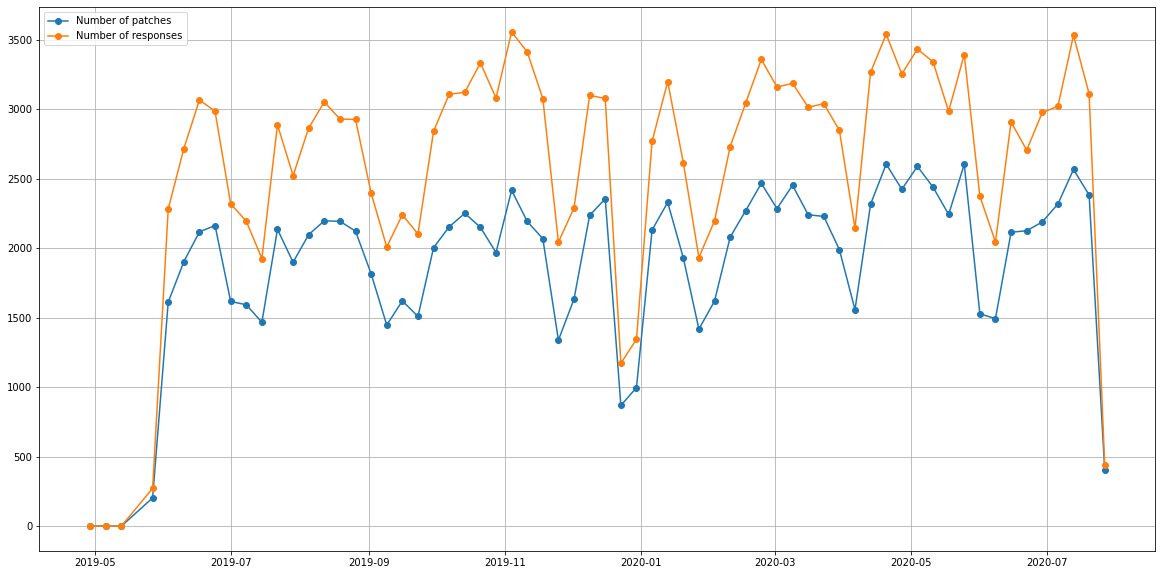

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(patch_counts['date'],
        patch_counts['patch_id'],
        marker='o')

ax.plot(response_counts['date'],
        response_counts['resp_msg_id'],
        marker='o')

ax.grid()

ax.legend(['Number of patches', 'Number of responses'])

In [10]:
patch_counts = patch_responses.groupby(['mailing_list', 'date'])\
                                .nunique()['patch_id']\
                                .reset_index()\
                                .sort_values('date')
response_counts = patch_responses.groupby(['mailing_list', 'date'])\
                                    .nunique()['resp_msg_id']\
                                    .reset_index()\
                                    .sort_values('date')

top_patch_lists = patch_responses.groupby('mailing_list').nunique()['patch_id']\
                .sort_values(ascending=False)[:10].reset_index()['mailing_list']
top_response_lists = patch_responses.groupby('mailing_list').nunique()['resp_msg_id']\
                .sort_values(ascending=False)[:10].reset_index()['mailing_list']

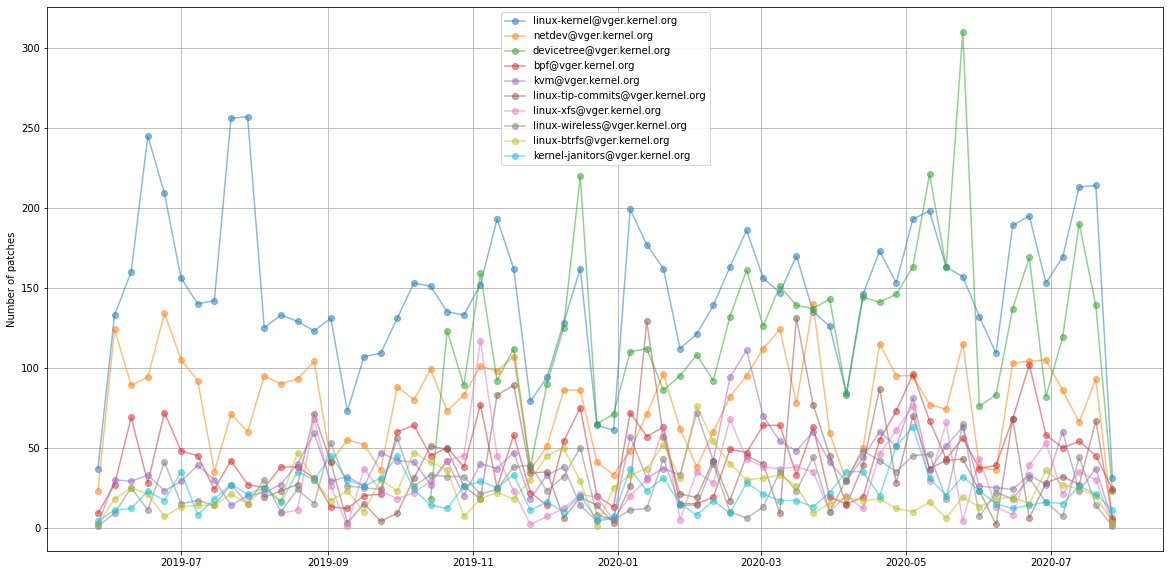

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

for mailing_list in top_patch_lists:
    mask = patch_counts['mailing_list'] == mailing_list
    ax.plot(patch_counts.loc[mask]['date'],
            patch_counts.loc[mask]['patch_id'],
            marker='o', alpha=0.5)
ax.grid()

ax.set_ylabel('Number of patches')

ax.legend(top_patch_lists)

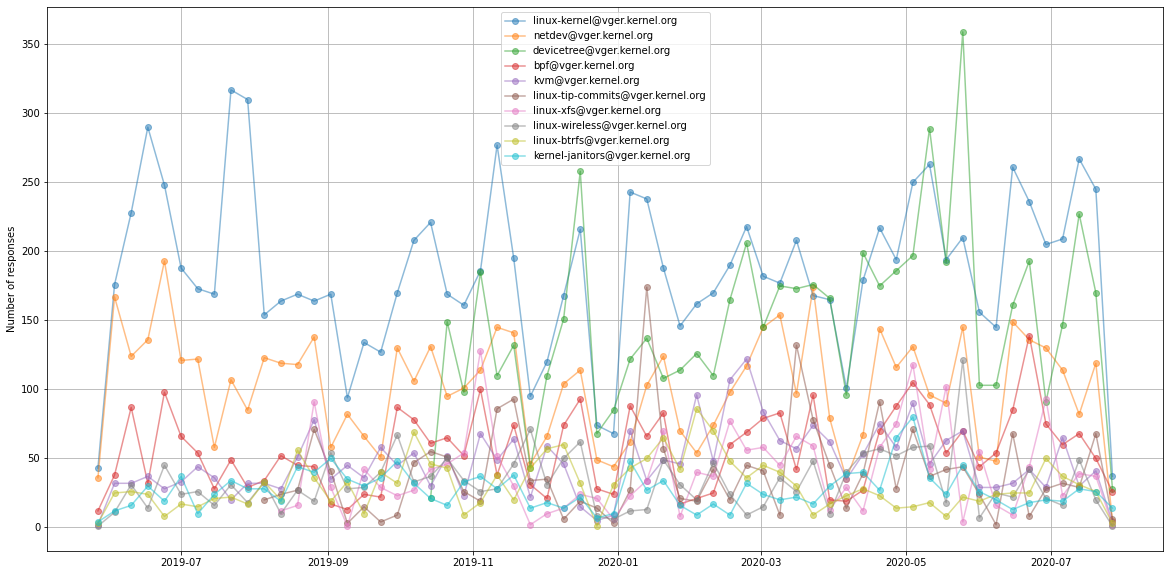

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))

for mailing_list in top_response_lists:
    mask = response_counts['mailing_list'] == mailing_list
    ax.plot(response_counts.loc[mask]['date'],
            response_counts.loc[mask]['resp_msg_id'],
            marker='o', alpha=0.5)
ax.grid()
ax.set_ylabel('Number of responses')

ax.legend(top_response_lists)

In [13]:
commit_counts = patch_responses.groupby(['mailing_list', 'date'])\
                                .nunique()['upstream']\
                                .reset_index()\
                                .sort_values('date')

top_commit_lists = patch_responses.groupby('mailing_list').nunique()['upstream']\
                .sort_values(ascending=False)[:10].reset_index()['mailing_list']


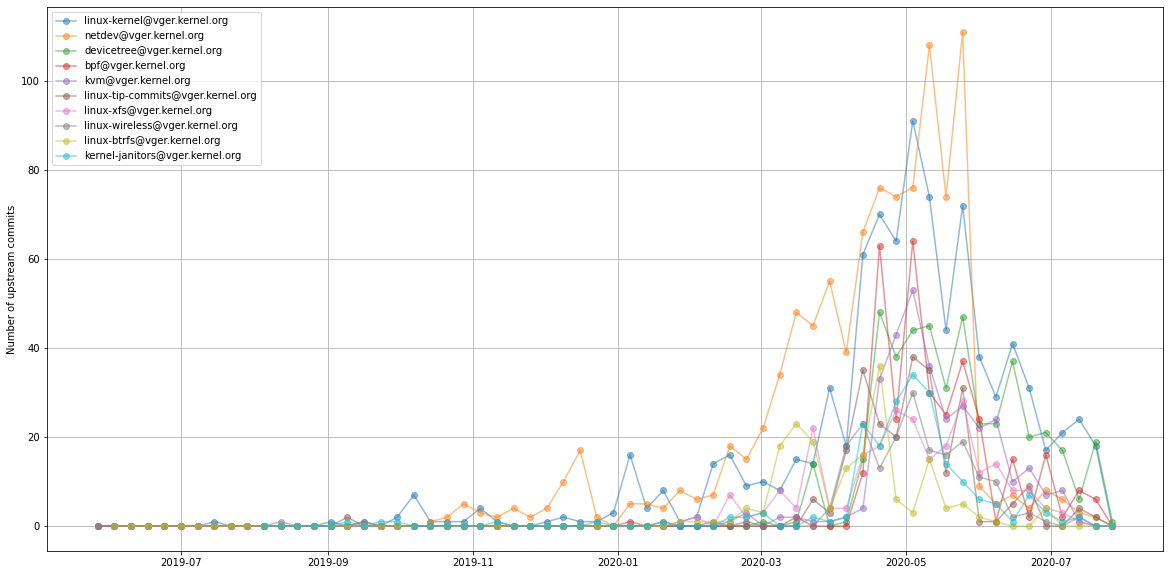

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

for mailing_list in top_commit_lists:
    mask = commit_counts['mailing_list'] == mailing_list
    ax.plot(commit_counts.loc[mask]['date'],
            commit_counts.loc[mask]['upstream'],
            marker='o', alpha=0.5)
ax.grid()

ax.set_ylabel('Number of upstream commits')

ax.legend(top_patch_lists)